#### <p style="text-align: center; font-size: 20px">1. Setup</p>

In [10]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", color_codes=True)
sns.set_style('ticks')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### <p style="text-align: center; font-size: 20px">2. Loading data</p>

In [11]:
train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
sample_submission = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/sample_submission.csv')

#### <p style="text-align: center; font-size: 20px">3. Exploratory Data Analysis</p>

<b>3.1 General Analysis</b>

In [12]:
print('Rows and Columns in train dataset:', train.shape)
print('Rows and Columns in test dataset:', test.shape)
print('The shape of sample submission dataset: ', sample_submission.shape)

Rows and Columns in train dataset: (19158, 14)
Rows and Columns in test dataset: (2129, 13)
The shape of sample submission dataset:  (2129, 2)


In [13]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [15]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [17]:
sample_submission.head()

,enrollee_id,target
0,32403,0.5
1,9858,0.5
2,31806,0.5
3,27385,0.5
4,27724,0.5


In [18]:
print('Missing value in train dataset:', sum(train.isnull().sum()))
print('Missing value in test dataset:', sum(test.isnull().sum()))

Missing value in train dataset: 20733
Missing value in test dataset: 2204


<b>3.2 Features and Target Distribution</b>

Target 
- 0 - Not looking for job change
- 1 – Looking for a job change
  
As you can see, here we have imbalanced data.

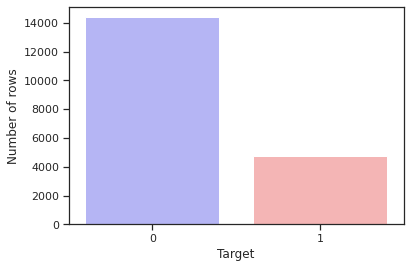

In [19]:
plt.figure(figsize=(6, 4))
sns.barplot(train.target.value_counts().index.astype(int),
            train.target.value_counts().values, palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.show();

Gender

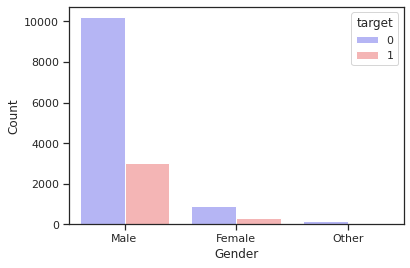

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(train.gender, palette='bwr', hue=train.target.astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show();

Experience

<span style="font-size:10px">Experience in years</span>

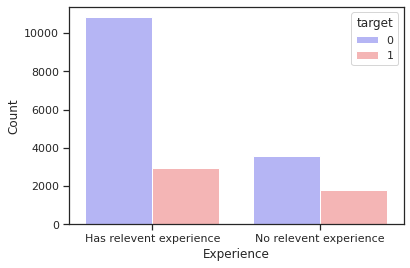

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(train.relevent_experience, palette='bwr', hue=train.target.astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Experience', fontsize=12)
plt.show();

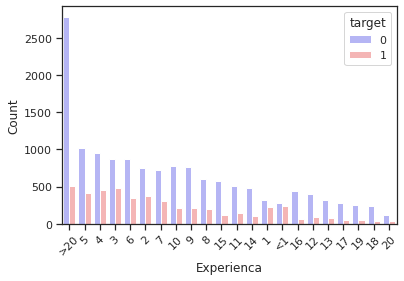

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(train.experience, palette='bwr', hue=train.target.astype(int),
              order=train.experience.value_counts().index)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Experienca', fontsize=12)
plt.xticks(rotation=45)
plt.show();

In [23]:
def experience(x):
    if x=='<1'      :   return '<1'
    if x=='1'       :   return '1-10' 
    if x=='2'       :   return '1-10' 
    if x=='3'       :   return '1-10' 
    if x=='4'       :   return '1-10' 
    if x=='5'       :   return '1-10'
    if x=='6'       :   return '1-10' 
    if x=='7'       :   return '1-10' 
    if x=='8'       :   return '1-10'  
    if x=='9'       :   return '1-10'  
    if x=='10'      :   return '1-10'  
    if x=='11'      :   return '11-20'
    if x=='12'      :   return '11-20'
    if x=='13'      :   return '11-20' 
    if x=='14'      :   return '11-20' 
    if x=='15'      :   return '11-20' 
    if x=='16'      :   return '11-20'
    if x=='17'      :   return '11-20'
    if x=='18'      :   return '11-20'
    if x=='19'      :   return '11-20' 
    if x=='20'      :   return '11-20' 
    if x=='>20'     :   return '>20'

train_experince = train.copy()
train_experince['experience'] = train_experince['experience'].apply(experience) 

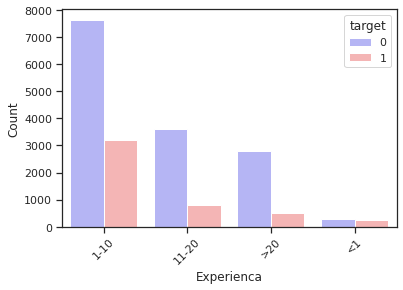

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(train_experince.experience, palette='bwr', hue=train.target.astype(int),
              order=train_experince.experience.value_counts().index)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Experienca', fontsize=12)
plt.xticks(rotation=45)
plt.show();

Enrolled university

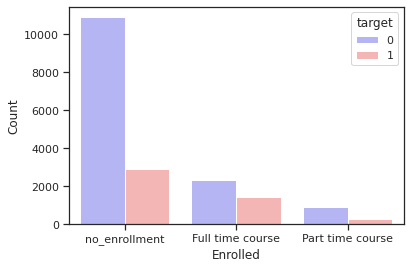

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(train.enrolled_university, palette='bwr', hue=train.target.astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Enrolled', fontsize=12)
plt.show();

Education level

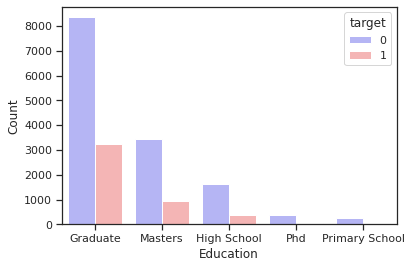

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(train.education_level, palette='bwr', hue=train.target.astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Education', fontsize=12)
plt.show();

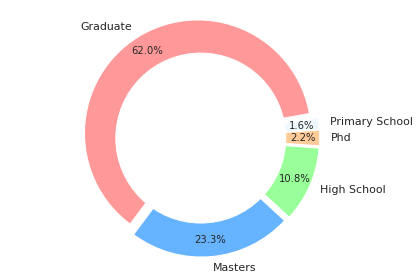

In [27]:
# pie chart

labels = train.education_level.value_counts().keys()
sizes = train.education_level.value_counts()

#add colors
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#f0f8ff']

#explsion
explode = (0.05, 0.05, 0.05, 0.05, 0.05)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=10, pctdistance=0.85, explode=explode,
        labeldistance=1.1)

centre_circle = plt.Circle((0, 0), 0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

Major discipline

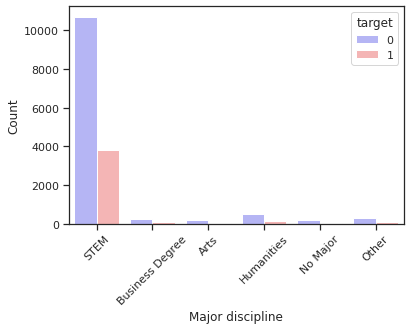

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(train.major_discipline, palette='bwr', hue=train.target.astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Major discipline', fontsize=12)
plt.xticks(rotation=45)
plt.show();

Company type

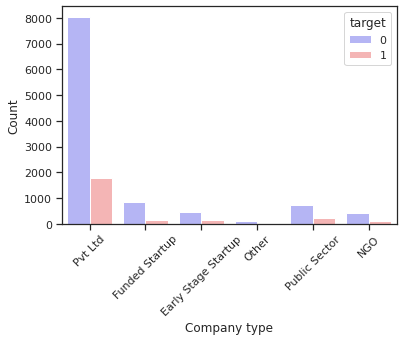

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(train.company_type, palette='bwr', hue=train.target.astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Company type', fontsize=12)
plt.xticks(rotation=45)
plt.show();

Company size

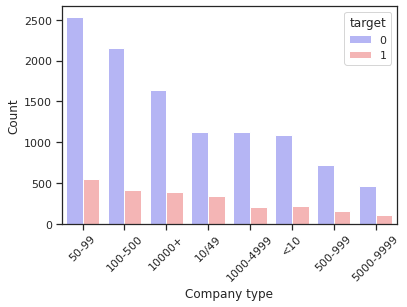

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(train.company_size, palette='bwr',
              hue=train.target.astype(int),
              order=train.company_size.value_counts().index)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Company type', fontsize=12)
plt.xticks(rotation=45)
plt.show();

Number of years between last and current job

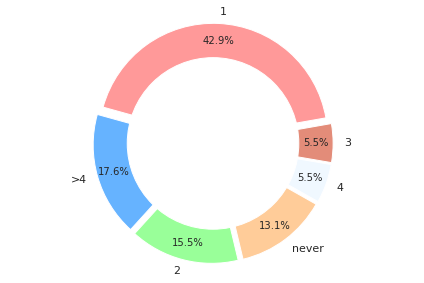

In [31]:
# pie chart

labels = train.last_new_job.value_counts().keys()
sizes = train.last_new_job.value_counts()

#add colors
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#f0f8ff', '#E38C79']

#explsion
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=10, pctdistance=0.85, explode=explode,
        labeldistance=1.1)

centre_circle = plt.Circle((0, 0), 0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

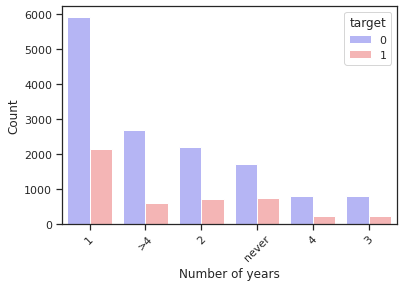

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(train.last_new_job, palette='bwr',
              hue=train.target.astype(int),
              order=train.last_new_job.value_counts().index)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of years', fontsize=12)
plt.xticks(rotation=45)
plt.show();

Training hours

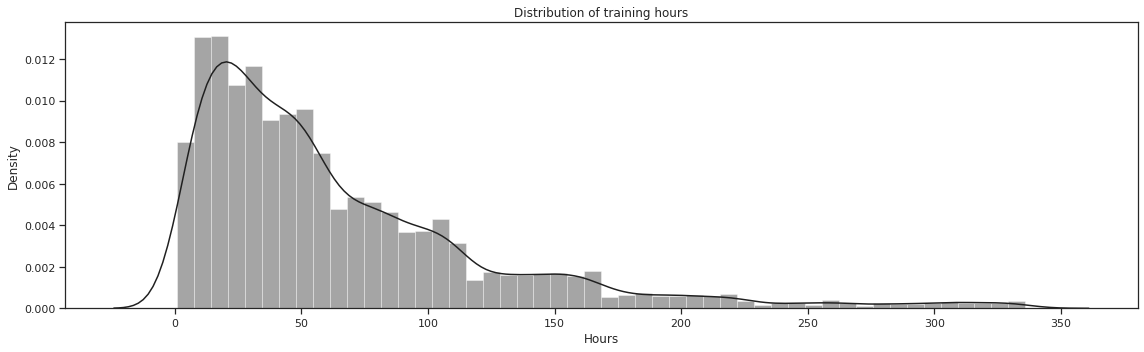

In [33]:
plt.figure(figsize=(16, 5))
sns.distplot(train.training_hours, color='#202020')
plt.title('Distribution of training hours')
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

#### <p style="text-align: center; font-size: 20px">4. Data Preprocessing</p>

Drop na and columns

In [34]:
train = train.drop(['enrollee_id', 'city', 'city_development_index', 'training_hours'], axis=1)
test = test.drop(['enrollee_id', 'city', 'city_development_index', 'training_hours'], axis=1)

train.experience = train.experience.apply(experience)
test.experience = test.experience.apply(experience) 

In [35]:
print('Train NA values: \n', train.isnull().sum())
print('Test NA values: \n', test.isnull().sum())

Train NA values: 
 gender                 4508
relevent_experience       0
enrolled_university     386
education_level         460
major_discipline       2813
experience               65
company_size           5938
company_type           6140
last_new_job            423
target                    0
dtype: int64
Test NA values: 
 gender                 508
relevent_experience      0
enrolled_university     31
education_level         52
major_discipline       312
experience               5
company_size           622
company_type           634
last_new_job            40
dtype: int64


In [36]:
def impute_nan_most_frequent_category(DataFrame, ColName):
    # .mode()[0] - gives first category name
    most_frequent_category = DataFrame[ColName].mode()[0]

    # replace nan values with most occured category
    DataFrame[ColName].fillna(most_frequent_category, inplace=True)

In [37]:
for i in train.select_dtypes(include = "object").columns:
    impute_nan_most_frequent_category(train, i)

for i in test.select_dtypes(include = "object").columns:
    impute_nan_most_frequent_category(test, i)

In [38]:
print('Train NA values: \n', train.isnull().sum())
print('Test NA values: \n', test.isnull().sum())

Train NA values: 
 gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
target                 0
dtype: int64
Test NA values: 
 gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64


Label Encoding

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               19158 non-null  object 
 1   relevent_experience  19158 non-null  object 
 2   enrolled_university  19158 non-null  object 
 3   education_level      19158 non-null  object 
 4   major_discipline     19158 non-null  object 
 5   experience           19158 non-null  object 
 6   company_size         19158 non-null  object 
 7   company_type         19158 non-null  object 
 8   last_new_job         19158 non-null  object 
 9   target               19158 non-null  float64
dtypes: float64(1), object(9)
memory usage: 1.5+ MB


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               2129 non-null   object
 1   relevent_experience  2129 non-null   object
 2   enrolled_university  2129 non-null   object
 3   education_level      2129 non-null   object
 4   major_discipline     2129 non-null   object
 5   experience           2129 non-null   object
 6   company_size         2129 non-null   object
 7   company_type         2129 non-null   object
 8   last_new_job         2129 non-null   object
dtypes: object(9)
memory usage: 149.8+ KB


In [41]:
objList = train.select_dtypes(include = "object").columns
print('Categorical columns: ', objList)

Categorical columns:  Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


In [42]:
le = preprocessing.LabelEncoder()
train_encoded = train.copy()
test_encoded = test.copy()
for feat in objList:
    train_encoded[feat] = le.fit_transform(train[feat].astype(str))
    test_encoded[feat] = le.fit_transform(test[feat].astype(str))

In [43]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               19158 non-null  int64  
 1   relevent_experience  19158 non-null  int64  
 2   enrolled_university  19158 non-null  int64  
 3   education_level      19158 non-null  int64  
 4   major_discipline     19158 non-null  int64  
 5   experience           19158 non-null  int64  
 6   company_size         19158 non-null  int64  
 7   company_type         19158 non-null  int64  
 8   last_new_job         19158 non-null  int64  
 9   target               19158 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 1.5 MB


In [44]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   gender               2129 non-null   int64
 1   relevent_experience  2129 non-null   int64
 2   enrolled_university  2129 non-null   int64
 3   education_level      2129 non-null   int64
 4   major_discipline     2129 non-null   int64
 5   experience           2129 non-null   int64
 6   company_size         2129 non-null   int64
 7   company_type         2129 non-null   int64
 8   last_new_job         2129 non-null   int64
dtypes: int64(9)
memory usage: 149.8 KB


In [45]:
X = train_encoded.drop('target', axis=1)
y = train_encoded.target

#### <p style="text-align: center; font-size: 20px">4. Data Upsampling Using SMOTE</p>

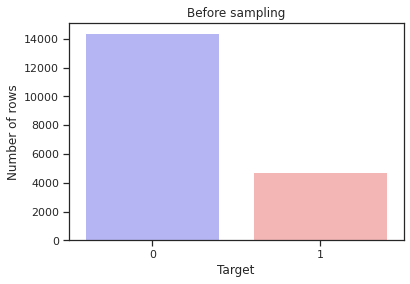

In [46]:
plt.figure(figsize=(6, 4))
sns.barplot(y.value_counts().index.astype(int),
            y.value_counts().values, palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.title('Before sampling')
plt.show()

In [47]:
oversample = SMOTE()
smote = SMOTE(random_state = 0)
X_smote, y_smote = smote.fit_resample(X,y)

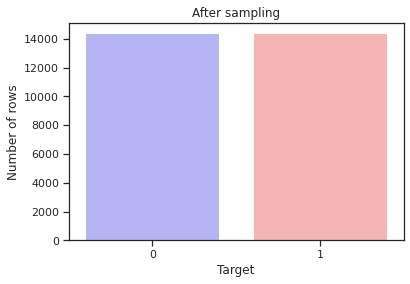

In [48]:
plt.figure(figsize=(6, 4))
sns.barplot(y_smote.value_counts().index.astype(int),
            y_smote.value_counts().values, palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.title('After sampling')
plt.show()


#### <p style="text-align: center; font-size: 20px">5. Feature selection</p>

In [49]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest, f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=9)
fit = bestfeatures.fit(X_smote,y_smote)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Specs       Score
2  enrolled_university  858.244164
5           experience  637.956764
1  relevent_experience  426.050187
3      education_level  383.285454
7         company_type   92.227637
6         company_size   67.479073
8         last_new_job   53.814328
0               gender   22.636806
4     major_discipline    5.374964


In [50]:
X_smote = X_smote.drop(['company_type', 'gender',
                        'relevent_experience'],
                       axis=1)

test_encoded = test_encoded.drop(['company_type', 'gender',
                                  'relevent_experience'],
                                 axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,
                                                    y_smote,
                                                    test_size=0.2,
                                                    random_state=42)

#### <p style="text-align: center; font-size: 20px">6. Model Selection</p>

In [52]:
rf_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=42)) ])
ada_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",AdaBoostClassifier(random_state=42,learning_rate=0.7)) ])
svm_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",SVC(random_state=42,kernel='rbf')) ])
xgb_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",XGBClassifier(random_state=42, n_jobs = 2)) ])

rf_roc_auc_cross_val_scores = cross_val_score(rf_pipe,X_train,y_train,cv=5,scoring='roc_auc')
ada_roc_auc_cross_val_scores=cross_val_score(ada_pipe,X_train,y_train,cv=5,scoring='roc_auc')
svm_roc_auc_cross_val_scores=cross_val_score(svm_pipe,X_train,y_train,cv=5,scoring='roc_auc')
xgb_roc_auc_cross_val_scores=cross_val_score(xgb_pipe,X_train,y_train,cv=5,scoring='roc_auc')

[15:01:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [53]:
print('Rndmforest validation score: ', rf_roc_auc_cross_val_scores.max())
print('Ada validation score: ', ada_roc_auc_cross_val_scores.max())
print('SVM validation score: ', svm_roc_auc_cross_val_scores.max())
print('Xgb validation score: ', xgb_roc_auc_cross_val_scores.max())

Rndmforest validation score:  0.7205514636513686
Ada validation score:  0.689560115639703
SVM validation score:  0.6811917460824715
Xgb validation score:  0.7150564320144237


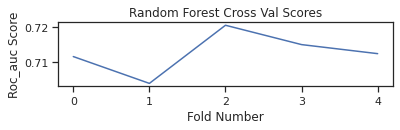

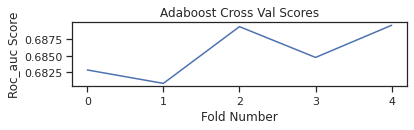

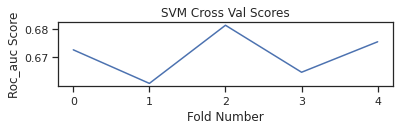

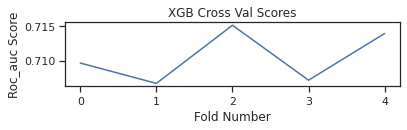

In [54]:
plt.subplot(3,1,1)
ax = sns.lineplot(x=range(0,len(rf_roc_auc_cross_val_scores)),y=rf_roc_auc_cross_val_scores)
ax.set_title('Random Forest Cross Val Scores')
ax.set_xticks([i for i in range(0,len(rf_roc_auc_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('Roc_auc Score')
plt.show()

plt.subplot(3,1,2)
ax = sns.lineplot(x=range(0,len(ada_roc_auc_cross_val_scores)),y=ada_roc_auc_cross_val_scores)
ax.set_title('Adaboost Cross Val Scores')
ax.set_xticks([i for i in range(0,len(ada_roc_auc_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('Roc_auc Score')
plt.show()

plt.subplot(3,1,3)
ax = sns.lineplot(x=range(0,len(svm_roc_auc_cross_val_scores)),y=svm_roc_auc_cross_val_scores)
ax.set_title('SVM Cross Val Scores')
ax.set_xticks([i for i in range(0,len(svm_roc_auc_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('Roc_auc Score')
plt.show()

plt.subplot(3,1,3)
ax = sns.lineplot(x=range(0,len(xgb_roc_auc_cross_val_scores)),y=xgb_roc_auc_cross_val_scores)
ax.set_title('XGB Cross Val Scores')
ax.set_xticks([i for i in range(0,len(xgb_roc_auc_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('Roc_auc Score')
plt.show()

#### <p style="text-align: center; font-size: 20px">7. Model Evaluation</p>

In [55]:
rf_pipe.fit(X_train, y_train)
rf_prediction = rf_pipe.predict(X_test)

ada_pipe.fit(X_train, y_train)
ada_prediction = ada_pipe.predict(X_test)

svm_pipe.fit(X_train, y_train)
svm_prediction = svm_pipe.predict(X_test)

xgb_pipe.fit(X_train, y_train)
xgb_prediction = xgb_pipe.predict(X_test)

print('Roc_auc Score of Random Forest Model On Test Set - {}'.format(roc_auc_score(rf_prediction, y_test)))
print('Roc_auc Score of AdaBoost Model On Test Set - {}'.format(roc_auc_score(ada_prediction, y_test)))
print('Roc_auc Score of SVM Model On Test Set - {}'.format(roc_auc_score(svm_prediction, y_test)))
print('Roc_auc Score of XGB Model On Test Set - {}'.format(roc_auc_score(xgb_prediction, y_test)))

[15:01:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Roc_auc Score of Random Forest Model On Test Set - 0.6646337297894571
Roc_auc Score of AdaBoost Model On Test Set - 0.6285549313244663
Roc_auc Score of SVM Model On Test Set - 0.6293276080969814
Roc_auc Score of XGB Model On Test Set - 0.6631296859384846


#### <p style="text-align: center; font-size: 20px">8. Tuning Hyperparameters </p>

In [56]:
forest  = RandomForestClassifier(random_state = 42)

params = {
        'n_estimators' : [100, 300, 500, 800, 1200],
        'max_depth' : [5, 8, 15, 25, 30],
        'min_samples_split' : [2, 5, 10, 15, 100],
        'min_samples_leaf' : [1, 2, 5, 10] 
        }

gridF = RandomizedSearchCV(forest, params, cv = 5, verbose = 1)

In [57]:
clf_grid = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.8min finished


In [58]:
clf_grid.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 25}

In [59]:
best_est = clf_grid.best_estimator_

In [60]:
y_pred = best_est.predict(X_test)

In [61]:
print('Roc_auc Score of Random Forest Model On Test Set - {}'.format(roc_auc_score(y_pred, y_test)))

Roc_auc Score of Random Forest Model On Test Set - 0.6649273537314366


#### <p style="text-align: center; font-size: 20px">9. Prediction </p>

In [62]:
model = RandomForestClassifier(n_estimators=800,
                               min_samples_split=12,
                               min_samples_leaf=2, 
                               max_depth=15)

In [63]:
model.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=800)

In [64]:
prediction = model.predict(test_encoded)

In [65]:
sample_submission.target = prediction

In [66]:
sample_submission.head()

,enrollee_id,target
0,32403,1.0
1,9858,1.0
2,31806,1.0
3,27385,0.0
4,27724,0.0
